In [102]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

In [103]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/home/ubuntu/data/dogscats/sample/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/dogscats/sample/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')



Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [109]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

K.set_image_data_format('channels_first')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(1, 150, 150)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [110]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 148, 148)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 148, 148)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 700929    
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 701,249
Trainable params: 701,249
Non-trainable params: 0
_________________________________________________________________


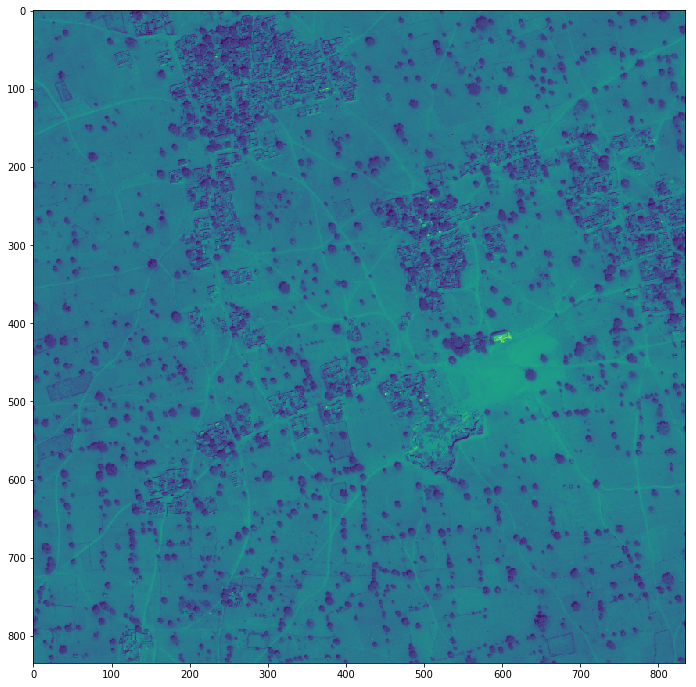

In [78]:
model.fit_generator(
        train_generator,
        steps_per_epoch=160,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=40)

In [79]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [80]:
# def stick_all_train():

s = 835

x = np.zeros((5 * s, 5 * s, 9))
y = np.zeros((5 * s, 5 * s, N_Cls))

ids = sorted(DF.ImageId.unique())
print len(ids)
for i in range(5):
    for j in range(5):
        id = ids[5 * i + j]


        img = np.expand_dims(P(id), axis=3)
        img = stretch_n(img)
        print img.shape, id, np.amax(img), np.amin(img)
        x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
        for z in range(N_Cls):
            y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

print np.amax(y), np.amin(y)

25


IOError: [Errno 2] No such file or directory: '/home/ubuntu/data/dstl/sixteen_band/test/6010_1_2_P.tif'

In [98]:
id = '6060_4_2'
img = np.expand_dims(P(id), axis=3)
img = stretch_n(img)

y = generate_mask_for_image_and_class((img.shape[0], img.shape[1]), id, 10)
np.amax(y), np.amin(y)


(0, 0)

In [82]:
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

In [59]:
img.shape

(4175, 4175, 9)

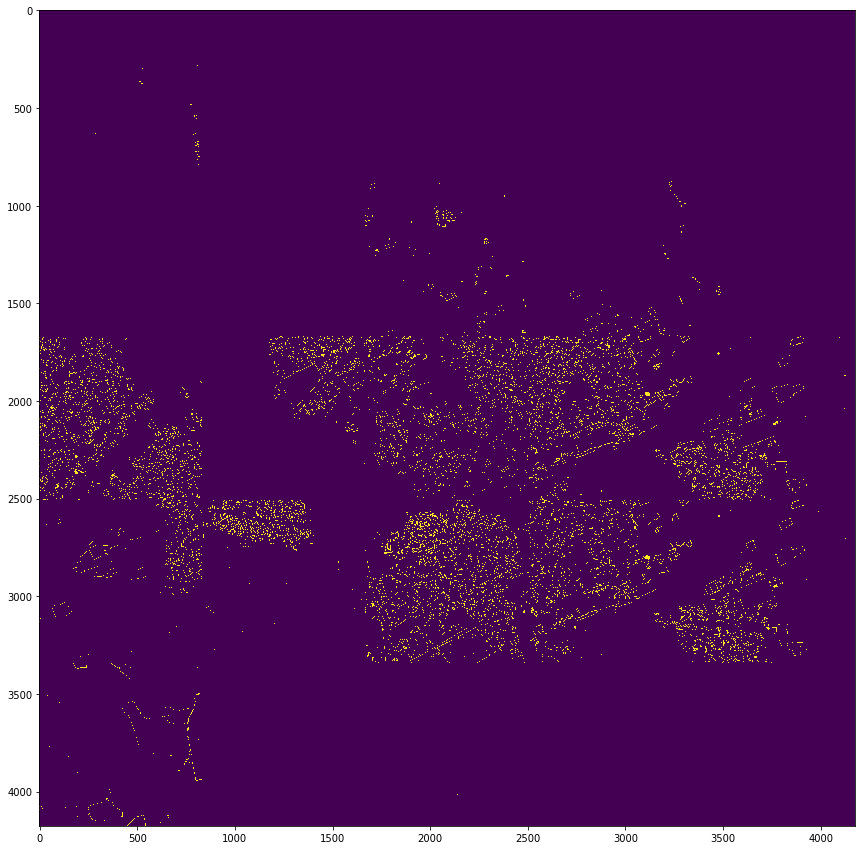

In [100]:
plt.figure(figsize=(15,15))
plt.imshow(msk[:,:,1])
plt.show()

In [ ]:

inputs = Input((9, 20, 20))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)